## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, LearningCurveDisplay, ValidationCurveDisplay, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Functions

In [2]:
# creat table for missing data
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    return missing_data

# plot learning curve
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1,1.0,5)):
    fig, ax = plt.subplots()
    params = {
        "X": x,
        "y": y,
        "train_sizes": train_sizes,
        "cv": cv,
        "score_type": "both",
        "n_jobs": n_jobs,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Score"
    }
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    LearningCurveDisplay.from_estimator(estimator, **params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles, ["Training Score", "Test Score"])
    plt.show()

# plot validation curve
def plot_validation_curve(estimator, title, x, y, param_name, param_range, cv=5):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.ylim((0.7, 1))
    params = {
        "X": x,
        "y": y,
        "param_name": param_name,
        "param_range": param_range,
        "cv": cv,
        "scoring": "r2",
        "score_name": "Score"
    }
    ValidationCurveDisplay.from_estimator(estimator, **params, n_jobs=-1, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles, ["Training Score", "Test Score"])
    plt.show()

## 1. Model mockup
In this section, we will create and test out a model to see its accuracy and efficiency, and if there is any area for improvement.
### 1.1. Overview

In [3]:
df = pd.read_csv("C:/Users/HP/Downloads/archive/StudentPerformanceFactors.csv")
df_raw = df.copy() # just in case

df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


**Definitions:**
- **Hours_Studied**: Number of hours spent studying per week.
- **Attendance**: Percentage of classes attended.
- **Parental_Involvement**: Level of parental involvement in the student's education (Low, Medium, High).
- **Access_to_Resources**: Availability of educational resources (Low, Medium, High).
- **Extracurricular_Activities**: Participation in extracurricular activities (Yes, No). Should be encoded.
- **Sleep_Hours**: Average number of hours of sleep per night.
- **Previous_Scores**: Scores from previous exams.
- **Motivation_Level**: Student's level of motivation (Low, Medium, High).
- **Internet_Access**: Availability of internet access (Yes, No). Should be encoded.
- **Tutoring_Sessions**: Number of tutoring sessions attended per month.
- **Family_Income**: Family income level (Low, Medium, High).
- **Teacher_Quality**: Quality of the teachers (Low, Medium, High).
- **School_Type**: Type of school attended (Public, Private). Should be encoded.
- **Peer_Influence**: Influence of peers on academic performance (Positive, Neutral, Negative).
- **Physical_Activity**: Average number of hours of physical activity per week.
- **Learning_Disabilities**: Presence of learning disabilities (Yes, No). Should be encoded.
- **Parental_Education_Level**: Highest education level of parents (High School, College, Postgraduate). Should be encoded.
- **Distance_from_Home**: Distance from home to school (Near, Moderate, Far).
- **Gender**: Gender of the student (Male, Female). Should be encoded.
- **Exam_Score**: Final exam score.

In [4]:
df.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


First thing to notice is the maximum exam score is 101, which exceeds the 100 score system, which we will come back and handle later.

In [5]:
df.describe(include=["object"])

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
count,6607,6607,6607,6607,6607,6607,6529,6607,6607,6607,6517,6540,6607
unique,3,3,2,3,2,3,3,2,3,2,3,3,2
top,Medium,Medium,Yes,Medium,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
freq,3362,3319,3938,3351,6108,2672,3925,4598,2638,5912,3223,3884,3814


### 1.2. Filling missing data

In [6]:
missing_data_table(df)

,Total,Percent
Parental_Education_Level,90,0.013622
Teacher_Quality,78,0.011806
Distance_from_Home,67,0.010141
Hours_Studied,0,0.000000
Attendance,0,0.000000
Gender,0,0.000000
Learning_Disabilities,0,0.000000
Physical_Activity,0,0.000000
Peer_Influence,0,0.000000
School_Type,0,0.000000


Due to the low percentage of missing values, we will delete the observations missing Parental_Education_Level, Teacher_Quality, and Distance_from_Home.

In [7]:
df.drop(df[pd.isnull(df["Parental_Education_Level"])].index, inplace=True)
df.drop(df[pd.isnull(df["Teacher_Quality"])].index, inplace=True)
df.drop(df[pd.isnull(df["Distance_from_Home"])].index, inplace=True)
missing_data_table(df)

,Total,Percent
Hours_Studied,0,0.0
Attendance,0,0.0
Gender,0,0.0
Distance_from_Home,0,0.0
Parental_Education_Level,0,0.0
Learning_Disabilities,0,0.0
Physical_Activity,0,0.0
Peer_Influence,0,0.0
School_Type,0,0.0
Teacher_Quality,0,0.0


### 1.3. Preparing the data

In [8]:
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [9]:
# define categorical variables
object_features = [
    "Parental_Involvement",
    "Access_to_Resources",
    "Extracurricular_Activities",
    "Motivation_Level",
    "Internet_Access",
    "Family_Income",
    "Teacher_Quality",
    "School_Type",
    "Peer_Influence",
    "Learning_Disabilities",
    "Parental_Education_Level",
    "Distance_from_Home",
    "Gender"
]
for col in object_features:
    df[col] = pd.Categorical(df[col])
df.dtypes

Hours_Studied                    int64
Attendance                       int64
Parental_Involvement          category
Access_to_Resources           category
Extracurricular_Activities    category
Sleep_Hours                      int64
Previous_Scores                  int64
Motivation_Level              category
Internet_Access               category
Tutoring_Sessions                int64
Family_Income                 category
Teacher_Quality               category
School_Type                   category
Peer_Influence                category
Physical_Activity                int64
Learning_Disabilities         category
Parental_Education_Level      category
Distance_from_Home            category
Gender                        category
Exam_Score                       int64
dtype: object

In [10]:
# one-hot encoding
ordinal_data = ["Parental_Involvement", "Access_to_Resources", "Distance_from_Home", "Parental_Education_Level", "Peer_Influence", "Teacher_Quality", "Family_Income", "Motivation_Level"]
ordinal_df = df[ordinal_data]
df = pd.get_dummies(df.drop(*[ordinal_data], axis=1), drop_first=True)
df.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,23,84,7,73,0,3,67,False,True,True,False,True
1,19,64,8,59,2,4,61,False,True,True,False,False
2,24,98,7,91,2,4,74,True,True,True,False,True
3,29,89,8,98,1,4,71,True,True,True,False,True
4,19,92,6,65,3,4,70,True,True,True,False,False


In [11]:
# ordinal encoding
for col in ordinal_data:
    if ordinal_df[col].str.contains("Low").any():
        levels = {"Low": 0, "Medium": 1, "High": 2}
    elif ordinal_df[col].str.contains("Negative").any():
        levels = {"Negative": -1, "Neutral": 0, "Positive": 1}
    elif ordinal_df[col].str.contains("Near").any():
        levels = {"Near": 0, "Moderate": 1, "Far": 2}
    else:
        levels = {"High School": 0, "College": 1, "Postgraduate": 2}

    ordinal_df[col] = ordinal_df[col].map(levels)

ordinal_df.head()

,Parental_Involvement,Access_to_Resources,Distance_from_Home,Parental_Education_Level,Peer_Influence,Teacher_Quality,Family_Income,Motivation_Level
0,0,2,0,0,1,1,0,0
1,0,1,1,1,-1,1,1,0
2,1,1,0,2,0,1,1,1
3,0,1,1,0,-1,1,1,1
4,1,1,0,1,0,2,1,1


In [12]:
df = pd.concat([df, ordinal_df], axis=1)
df.astype(int)
df.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male,Parental_Involvement,Access_to_Resources,Distance_from_Home,Parental_Education_Level,Peer_Influence,Teacher_Quality,Family_Income,Motivation_Level
0,23,84,7,73,0,3,67,False,True,True,False,True,0,2,0,0,1,1,0,0
1,19,64,8,59,2,4,61,False,True,True,False,False,0,1,1,1,-1,1,1,0
2,24,98,7,91,2,4,74,True,True,True,False,True,1,1,0,2,0,1,1,1
3,29,89,8,98,1,4,71,True,True,True,False,True,0,1,1,0,-1,1,1,1
4,19,92,6,65,3,4,70,True,True,True,False,False,1,1,0,1,0,2,1,1


In [13]:
X = df.drop("Exam_Score", axis=1)
y = df[["Exam_Score"]]
df = pd.concat([X, y], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

### 1.4. Launching the model

In [14]:
lm = LinearRegression()
lm.fit(x_train, y_train)
scores = cross_val_score(lm, x_train, y_train, cv=10)
print(f"CV accuracy: {np.mean(scores)} +/- {np.std(scores)}")

CV accuracy: 0.706246369596091 +/- 0.1206421542400922


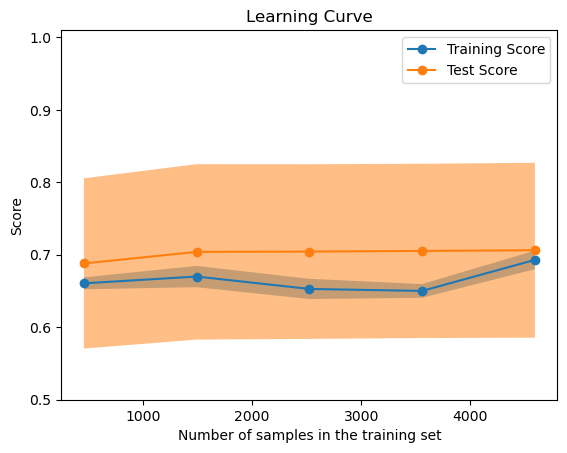

In [15]:
# assess model performance
title = "Learning Curve"
cv = 10
plot_learning_curve(lm, title, x_train, y_train, ylim=(0.5, 1.01), cv=cv)

The model might underfit since the learning curve converges to a low score value, and adding more data doesn't improve model's performance.

## 2. Enhanced model
### 2.1. Invalid value
First, let's delete invalid "Exam_Score" value. 

In [16]:
df.drop(df[df["Exam_Score"]>100].index, inplace=True)
df[df["Exam_Score"]>100]

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male,Parental_Involvement,Access_to_Resources,Distance_from_Home,Parental_Education_Level,Peer_Influence,Teacher_Quality,Family_Income,Motivation_Level,Exam_Score


### 2.2. Multicollinearity

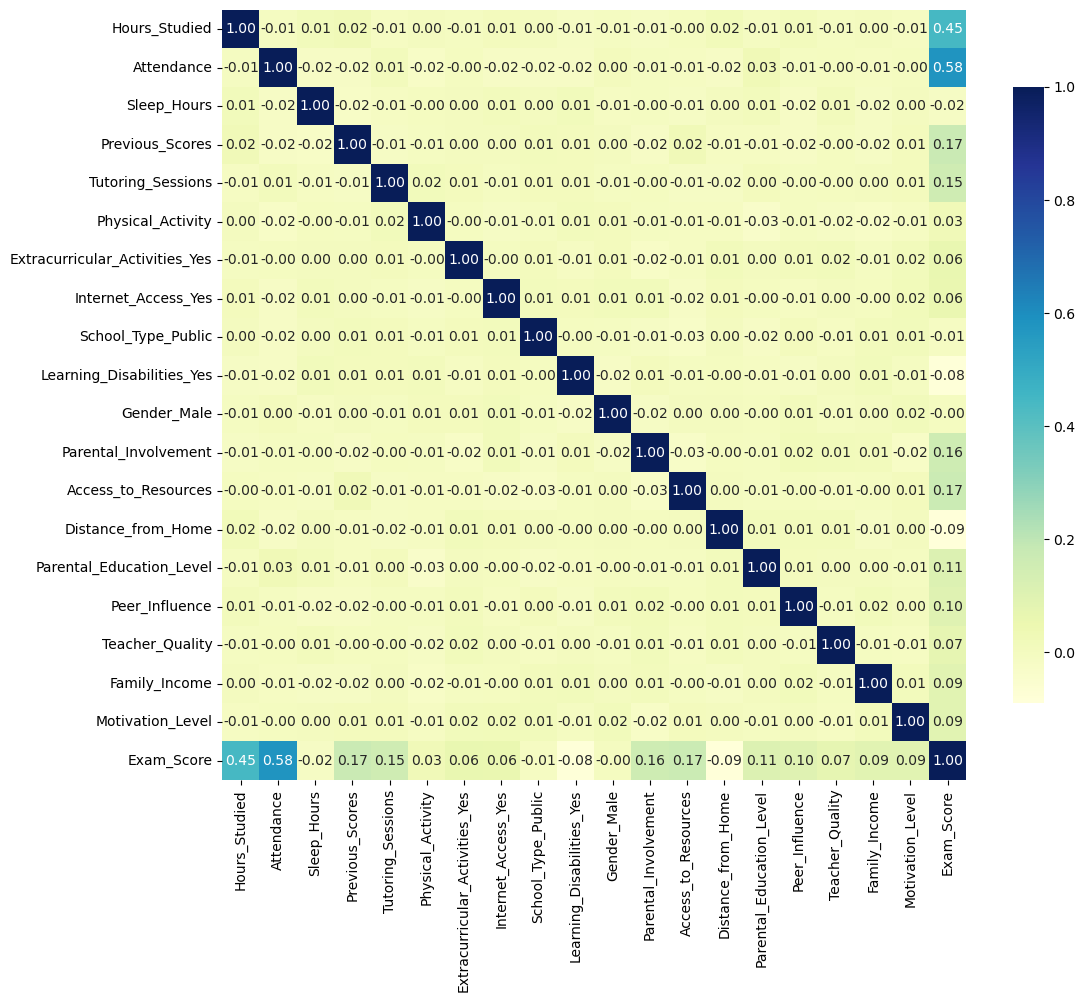

In [ ]:
# correlation heatmap
sns.set_theme()
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

Fortunately, there are no significant multicollinearity in this dataset. Besides "Hours_Studied" and "Attendance", almost no varibles show strong linear relationship with "Exam_Score". 

### 2.3. Normality

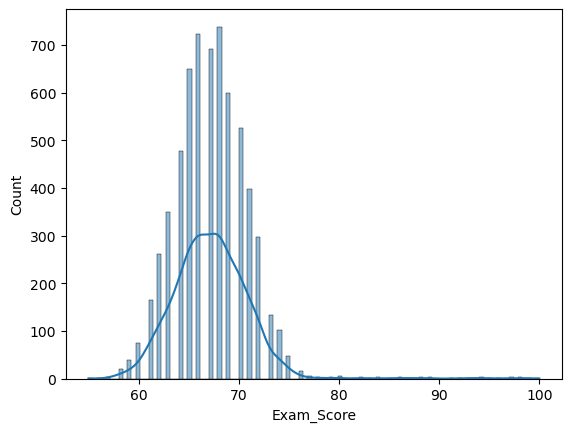

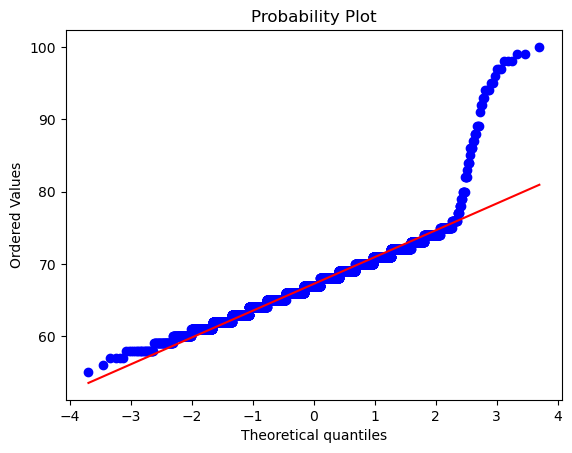

In [18]:
# check for normality of dependent variable
from scipy import stats
var = "Exam_Score"
sns.histplot(df[var], kde=True)
fig = plt.figure()
res = stats.probplot(df[var], plot=plt)
plt.show()

As "Exam_Score" reach its maximum, they deviate from the normality. We can almeliorate this by using box-cox transformation.

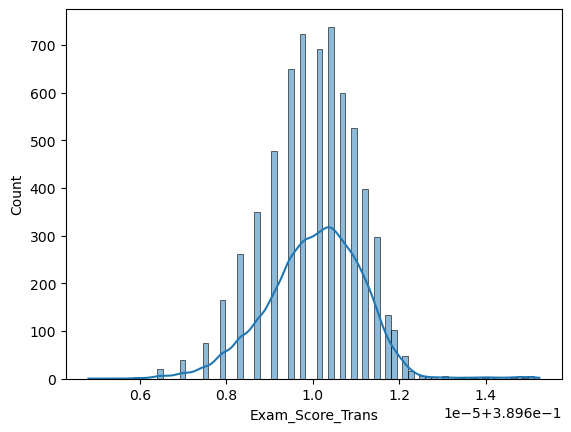

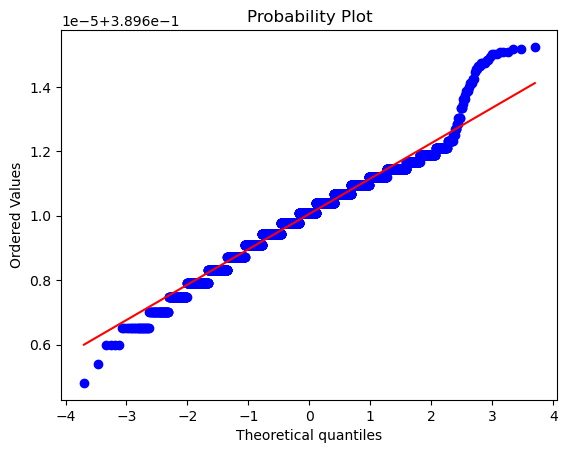

In [19]:
df["Exam_Score_Trans"], lambda_value = stats.boxcox(df[var])
sns.histplot(df["Exam_Score_Trans"], kde=True)
fig = plt.figure()
res = stats.probplot(df["Exam_Score_Trans"], plot=plt)
plt.show()

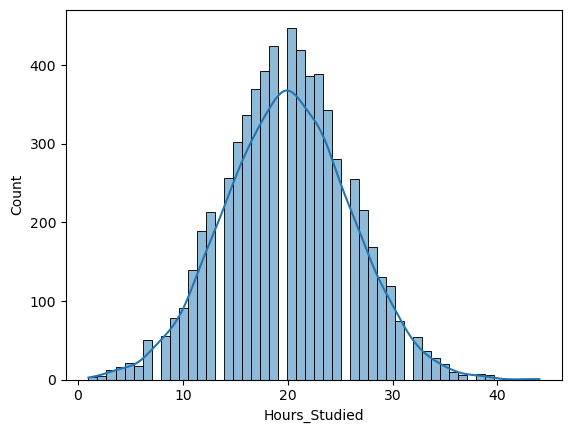

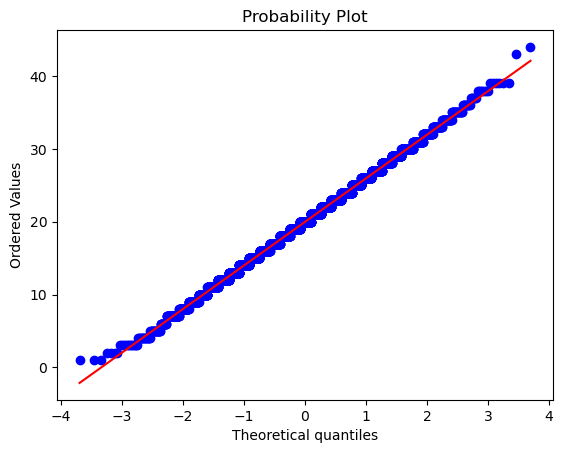

In [20]:
# check for normality of "Hours_Studied"
var = "Hours_Studied"
sns.histplot(df[var], kde=True)
fig = plt.figure()
res = stats.probplot(df[var], plot=plt)
plt.show()

Totally normal :D Next one, please!

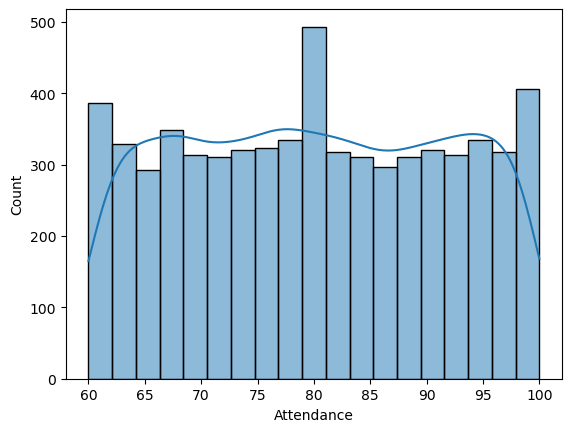

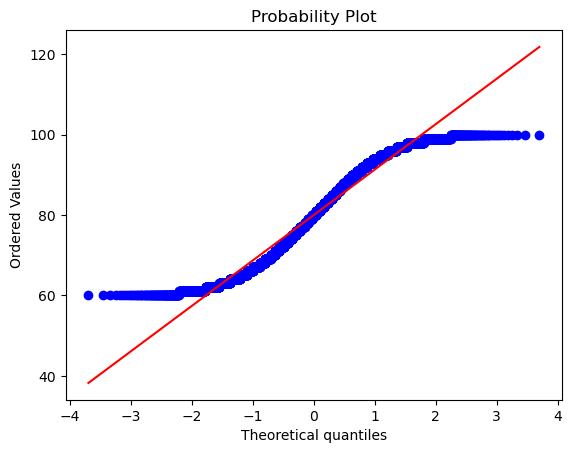

In [21]:
# check for normality of "Attendance"
var = "Attendance"
sns.histplot(df[var], kde=True)
fig = plt.figure()
res = stats.probplot(df[var], plot=plt)
plt.show()

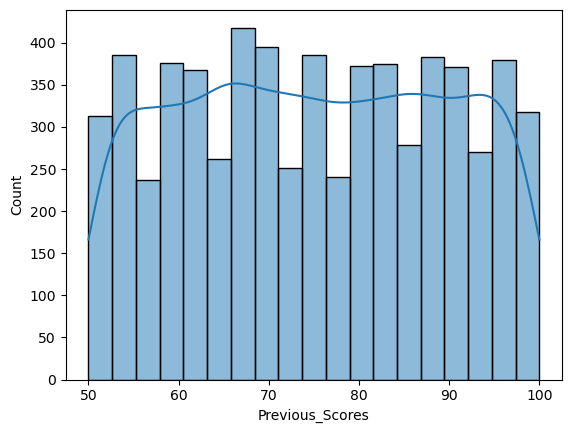

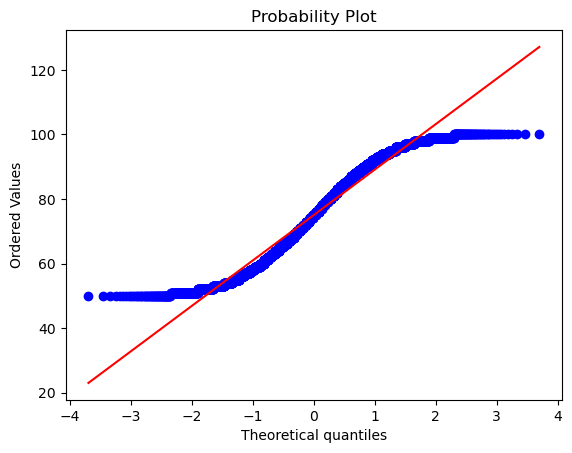

In [22]:
# check for normality of "Previous_Scores"
var = "Previous_Scores"
sns.histplot(df[var], kde=True)
fig = plt.figure()
res = stats.probplot(df[var], plot=plt)
plt.show()

Both graphs suggest "Attendance" and "Previous_Scores" follow uniform distribution, so I think it's better to scale them.

In [23]:
scaler = StandardScaler()
df["Attendance_Scaled"] = scaler.fit_transform(df[["Attendance"]])
df["Previous_Scores_Scaled"] = scaler.fit_transform(df[["Previous_Scores"]])
df.head()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,...,Distance_from_Home,Parental_Education_Level,Peer_Influence,Teacher_Quality,Family_Income,Motivation_Level,Exam_Score,Exam_Score_Trans,Attendance_Scaled,Previous_Scores_Scaled
0,23,84,7,73,0,3,False,True,True,False,...,0,0,1,1,0,0,67,0.389610,0.344803,-0.143302
1,19,64,8,59,2,4,False,True,True,False,...,1,1,-1,1,1,0,61,0.389608,-1.387019,-1.115616
2,24,98,7,91,2,4,True,True,True,False,...,0,2,0,1,1,1,74,0.389612,1.557079,1.106816
3,29,89,8,98,1,4,True,True,True,False,...,1,0,-1,1,1,1,71,0.389611,0.777759,1.592974
4,19,92,6,65,3,4,True,True,True,False,...,0,1,0,2,1,1,70,0.389611,1.037532,-0.698910


### 2.4. Fitting model
Now, for the grand finale, let's reinforce the model by using polynomial regression.

In [24]:
x = df.drop(["Exam_Score", "Exam_Score_Trans"], axis=1)
y = df[["Exam_Score_Trans"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=23)

In [25]:
plm = make_pipeline(PolynomialFeatures(), LinearRegression())
score = cross_val_score(plm, x_train, y_train, cv=10)
print(score.mean(), score.std())

0.8540468104351376 0.05244540021235484


As we can see, the R2 score has been improved!

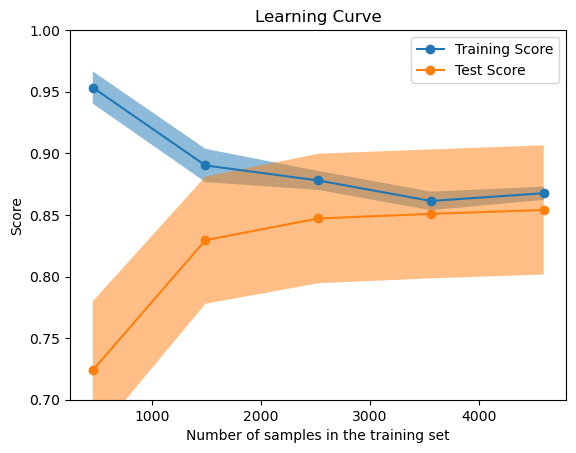

In [26]:
plot_learning_curve(plm, "Learning Curve", x_train, y_train, ylim=(0.7, 1), cv=10)

There is sign of overfitting initially, but as more samples are used, the gap closed. Therefore, I can safely say that our new model performs well.

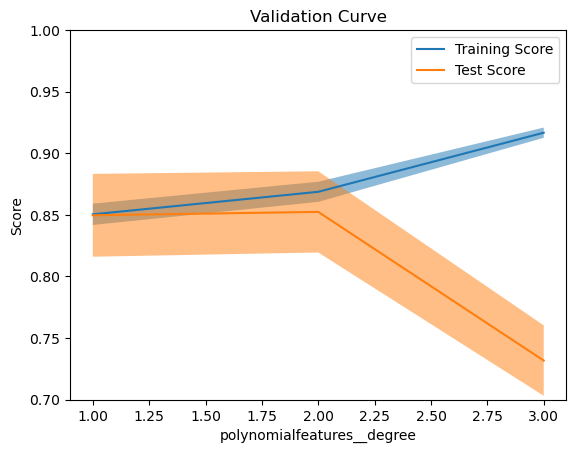

In [27]:
title = "Validation Curve"
param_name = "polynomialfeatures__degree"
param_range = [1,2,3]
plot_validation_curve(plm, title, x_train, y_train, param_name, param_range)

Test score remains unchange and then decreases drastically at degree 2 while training score continues to increases, so we will choose degree = 2.
### 2.5. Predict and Evaluate

In [28]:
plm.fit(x_train, y_train)
y_hat = plm.predict(x_test)

# inverse box-cox transformation for interpretive results
y_hat_inverted = (y_hat * lambda_value + 1) ** (1 / lambda_value)

y_hat, y_hat_inverted

(array([[0.38960858],
        [0.38961135],
        [0.38961037],
        ...,
        [0.38961061],
        [0.3896105 ],
        [0.38961113]]),
 array([[62.63748682],
        [71.58838215],
        [67.90974264],
        ...,
        [68.75908802],
        [68.38427588],
        [70.72801145]]))

In [ ]:
# evaluate using R2
score = cross_val_score(plm, x_test, y_test, cv=10)
print(score.mean())

0.8734432569851533


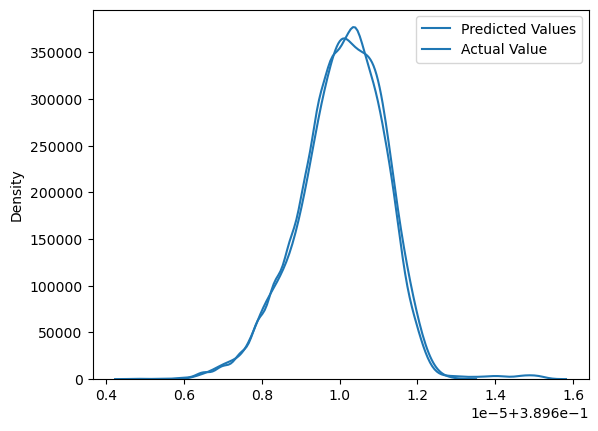

In [31]:
# evaluate using kde plot
ax = sns.kdeplot(y_hat, color="red", label="Predicted Values")
sns.kdeplot(y, color="blue", label="Actual Value", ax=ax)
ax.legend()
plt.show()